In [22]:
import numpy as np
import random
import itertools
from copy import deepcopy
import math

In [23]:
# hyper params
MATCH_ITER_LIMIT = 3 # n => n^2 => n^4 => n^8 => n^16, or can use CLS_LIMIT
MATCH_SIZE_LIMIT = 2 # subset with size <= limit can match wih other
GLOBAL_LIMIT = 1000 # when to add global limit, when C(n,m) is less than global limit
CLS_LIMIT = 1000
MAX_GRID = 500 # check var, use constant there 
CHECK_SUB_ON_INSERT = True

In [24]:
# function to print a 2-D board
def printA(A):
    n = len(A)
    # m = len(A[0])
    for i in range(n):
        print(A[i])
    print()

class Board:
    B = None #board
    H = None #hint
    n, m, nmine = None, None, None
    
    #@staticmethod
    def inrange(self, i, j):
        # print(i, j)
        return i >= 0 and i < self.n and j >= 0 and j < self.m
    
    def __init__(self, n, m, nmine): # return a list of starting hints
        self.n = n
        self.m = m
        self.nmine = nmine
        all_coordinate = [(i, j) for j in range(self.m) for i in range(self.n)]
        # print(all_coordinate)
        mine_pos = random.sample(all_coordinate, nmine)
        self.B = [[0]*self.m for i in range(self.n)]
        self.H = [[0]*self.m for i in range(self.n)]
        for p in mine_pos:
            self.B[p[0]][p[1]] = 1
        #printA(self.B)
        for i, j in itertools.product(range(self.n), range(self.m)):
            if(self.B[i][j] == 1):
                continue
            for dx, dy in itertools.product(range(-1,2,1), range(-1,2,1)):
                if(not (dx==0 and dy==0) and self.inrange(i+dx, j+dy)):
                    self.H[i][j] += self.B[i+dx][j+dy]
        #printA(self.H)
        return
    
    # for printing
    def __repr__(self):
        n = self.n
        m = self.m
        ret = ""
        for i in range(n):
            ret += str(self.B[i])
            ret += "\n"
        return ret
            
    def get_start(self, nstart = None):
        # get starting hints(starting safe positions)
        if(nstart == None):
            nstart = int(np.sqrt(self.n*self.m))
        hint_coordinate = list(filter(lambda x: self.B[x[0]][x[1]]==0 ,[(i, j) for j in range(self.m) for i in range(self.n)]))
        # printA(self.B)
        # print(hint_coordinate)
        start_pos = random.sample(hint_coordinate, nstart)
        #start = [[-1]*self.m for i in range(self.n)]
        #for p in start_pos:
        #    start[p[0]][p[1]] = self.H[p[0]][p[1]]
        return start_pos
        
    # query
    def q(self, i, j): #return -1 if is mine, return number if is hint
        return -1 if self.B[i][j] == 1 else self.H[i][j]
    def q(self, p): #return -1 if is mine, return number if is hint
        return -1 if self.B[p[0]][p[1]] == 1 else self.H[p[0]][p[1]]
                                            
    

In [25]:
class VAR:
    pos = None
    T = None # true / false, Mine/ Safe
    
    def __init__(self, pos, T):
        self.pos = pos
        self.T = T
    def __repr__(self):
        if self.T :
            return "M(%d,%d)"%(self.pos[0], self.pos[1])
        else:
            return "S(%d,%d)"%(self.pos[0], self.pos[1])
    
    def __eq__(self, rhs):
        if(isinstance(rhs, VAR)):
            return (self.pos == rhs.pos and self.T == rhs.T)
        else:
            return False
    # collision? 
    def __hash__(self):
        return hash(self.pos[0]*1000*10+self.pos[1]*10+self.T)
    
    def neg(self):
        return VAR(self.pos, not self.T)

class CLS: # Or of Variables
    # use set of variable is enough
    # to insert into KB need to be imutable(frozenset)
    pass

In [26]:
# Treat as an ADT(abstact data structure) that support desired op.s
# store kb and kb0
# kb: And of Variables
# kb0: inferenced ground truth
# fcls is inmmutable(frozen set)
class KB:
    kb = set()  # set of cls(frozenset of variable)
    kb0 = set() # set of variable
    max_kb = None
    cls_inserted = None
    
    def __init__(self):
        self.kb = set()
        self.kb0 = set()
        self.max_kb = 0
        self.cls_inserted = 0
    
    # return kb0's size
    def atom(self):
        return len(self.kb0)
    # return positive kb0's size
    def pos_atom(self):
        ret = 0
        for var in self.kb0: 
            ret += var.T
        return ret
    
    # return a singleton cls, or None 
    def get_single(self):
        for fcls in self.kb:
            if len(fcls) == 1:
                return next(iter(fcls))
        return None
    
    # add to kb0 
    def add_kb0(self, var):
        assert(var.neg() not in self.kb0)
        self.kb0.add(var) # kb0 is a set
        return
    
    # remove cls from kb
    def remove(self, fcls):
        assert(fcls in self.kb)
        self.kb.remove(fcls)
        return
    
    # remove cls and add to kb0 + resolution
    def transfer_to_kb0(self, var):
        self.remove(frozenset([var]))
        self.add_kb0(var)
        # resolution
        new_kb = []
        for fcls in self.kb:
            if var in fcls:
                #tautology
                continue
            elif var.neg() in fcls:
                cls = set(fcls)
                cls.remove(var.neg())
                fcls = frozenset(cls)
                assert(len(fcls) != 0)
                new_kb.append(fcls)
            else:
                new_kb.append(fcls)
        self.kb = set(new_kb)
        return
            
    
    # insert cls to kb
    # resolution with kb0 and check is not supperset(or eq) to other
    # assert not negative tautology
    def insert(self, cls, CHECKSUB = CHECK_SUB_ON_INSERT):
        # resolutions with kb0
        if(isinstance(cls, frozenset)):
            cls = set(cls)
        for truth in self.kb0:
            if truth in cls:
                # tautology
                return 
            elif truth.neg() in self.kb0:
                # this part is never True
                cls.remove(truth) # error handling should be redundunt
        
        # should not be negative tautology
        assert(len(cls) != 0)
        
        # check not supper set or equal to other this may be too much cost
        flag = True
        if(CHECKSUB):
            for fcls2 in self.kb:
                if(fcls2.issubset(cls)):
                    flag = False
                    break
        if flag:
            fcls = frozenset(cls)
            self.kb.add(fcls)
            self.cls_inserted += 1
            self.max_kb = max(self.max_kb, len(self.kb))
        return
    
    @staticmethod
    # passing cls2, cls are immutable
    # return set
    def get_match(cls2, cls):
        if(cls.issubset(cls2)):
            return cls
        elif(cls2.issubset(cls)):
            return cls2
        #check complements
        comp = []
        for var in cls2:
            if(var.neg() in cls):
                comp.append(var)
                
        if(len(comp) > 1):
            return None
        elif (len(comp) == 1):
            var = comp[0]
            resolution_cls = set(cls.union(cls2))
            resolution_cls.remove(var)
            resolution_cls.remove(var.neg())
            return resolution_cls
        else :
            return None
        
    # do pair wise match for cls with size 2
    def match(self):
        self.deal_sub()
        kb2 = [fcls for fcls in self.kb if len(fcls) <= 2]
        
        match_kb = []
        for fcls2 in kb2:
            for fcls in self.kb:
                m = KB.get_match(fcls2, fcls)
                if(m != None):
                    match_kb.append(m)
        for cls in match_kb:
            self.insert(cls)
        return
    
    # check pairwise subsumption and remove the less restricting ones
    # no dup in set
    # O(n^2)
    def deal_sub(self):
        new_kb = []
        n = len(self.kb)
        for fcls1 in self.kb:
            has_sub = False
            for fcls2 in self.kb:
                if(fcls1 != fcls2 and  fcls2.issubset(fcls1)):
                    has_sub = True
            if(not has_sub):
                new_kb.append(fcls1)
        self.kb = set(new_kb)
        return
    

In [27]:
class LogicAgent:
    b = None # game board in agent's hand
    B = None # solution, not used, will declare in solve as answer and return
    kb = None # current kowledge, include kb0(marked)
    
    def __init__(self):
        pass
    
    def solve(self, b, MATCH_ITER_LIMIT = MATCH_ITER_LIMIT, PRINT_FAIL = True, PRINT=False):
        # initializing solver
        self.b = b # game engine
        self.kb = KB() # KB
        B = [[-1]*b.m for i in range(b.n)]# answer, -1 not decided, 0 no mine, 1 mine
        kb = self.kb # sugar
        #b = self.b
        
        # get init positions
        start_pos = self.b.get_start()
        # add inital safe position to KB
        for p in start_pos:
            kb.insert({VAR(p, 0)})
        
        # start solving
        iteration = 0
        while(1):
            # is done
            if(kb.atom() == b.n*b.m):
                return B, (kb.atom(), b.n*b.m)
            
            if PRINT:
                iteration += 1
                print("ith iteration, i = ", iteration)
                printA(B)
                print(b)
            
            # check whether add global constraint now
            
            def comb(n, r):
                return math.factorial(n) // math.factorial(r) // math.factorial(n-r)
                
            if(comb(b.n*b.m - kb.atom(), b.nmine - kb.pos_atom()) < GLOBAL_LIMIT):
                undecided = []
                V0 = []
                V1 = []
                for i in range(b.n):
                    for j in range(b.m):
                        if(B[i][j] == -1):
                            undecided.append((i,j))
                            V0.append(VAR((i,j), 0))
                            V1.append(VAR((i,j), 1))
                assert(b.n*b.m - kb.atom() == len(V0))
                m = len(V0)
                n = b.nmine - kb.pos_atom()
                for cmb in itertools.combinations(V1, m-n+1):
                    kb.insert(set(cmb))
                for cmb in itertools.combinations(V0, n+1):
                    kb.insert(set(cmb))
        
            # get singleton
            cnt = 0
            while(kb.get_single() == None and cnt < MATCH_ITER_LIMIT):
                kb.match()
                cnt += 1
            if(kb.get_single() == None): # no any sigleton after matching limit
                if False:
                    print("Matching Limit Exceed!")
                return B, (kb.atom(), b.n*b.m)
                
            ## deal with sigleton
            a = kb.get_single() # a singleton cls's only var
            hint = b.q(a.pos)
            assert((hint == -1 and a.T == 1) or (hint != -1 and a.T == 0))
            ## common
            # 1. move to kb0
            # 2. matching of new kb0 to remainning cls
            i = a.pos[0]
            j = a.pos[1]
            kb.transfer_to_kb0(a)
            B[i][j] = a.T
            if(a.T == 0): # is safe and with hint res
                i = a.pos[0]
                j = a.pos[1]
                # undecided = []
                V0 = []
                V1 = []
                n = hint # should - positive B
                for dx, dy in itertools.product(range(-1,2,1), range(-1,2,1)):
                    nx, ny = i+dx, j+dy
                    if(not (dx==0 and dy==0) and b.inrange(nx, ny)):
                        if(B[nx][ny] == -1):
                            # undecided.append((nx, ny))
                            V0.append(VAR((nx,ny), 0))
                            V1.append(VAR((nx,ny), 1))
                        if(B[nx][ny] == 1):
                            n -= 1
                m = len(V0)
                # clause type, C m choose n, now at i, used array
                # use iter tool for higher performance
                for cmb in itertools.combinations(V1, m-n+1):
                    kb.insert(set(cmb))
                for cmb in itertools.combinations(V0, n+1):
                    kb.insert(set(cmb))

In [28]:
def exp(n, m, nmine, T=100, PRINT=100):
    import time
    grid_succ = 0
    grid_norm = 0
    all_succ = 0
    all_norm = 0
    max_kb = 0.0
    inserted_cls = 0.0
    elasped_time = 0.0
    
    for i in range(T):
        # init
        b = Board(n, m, nmine)
        agent = LogicAgent()
        
        #timing and solving
        start_time = time.time() 
        B, ri = agent.solve(b)
        end_time = time.time()
        
        #statistics
        elasped_time += end_time - start_time
        inserted_cls += agent.kb.cls_inserted
        max_kb += agent.kb.max_kb
        
        grid_succ += ri[0]
        grid_norm += ri[1]
        all_succ  += ri[0]==ri[1]
        all_norm  += 1
        if(PRINT != False and i%PRINT == 0):
            print("inserted cls", agent.kb.cls_inserted)
            print("maximum size of kb", agent.kb.max_kb)
            print("time spent", end_time - start_time)
            print("solution")
            printA(B)
            print("task")
            print(b)
    return (grid_succ, grid_norm), (all_succ,all_norm), (elasped_time/T, inserted_cls/T, max_kb/T)

In [32]:
d_exp = []
for i in range(8):
    expi = exp(9, 9, 5*i, 33, False)
    d_exp.append(expi)
    print(i, "done")

0 done
1 done
2 done
3 done
4 done
5 done
6 done
7 done


In [33]:
for i in range(8):
    print(d_exp[i])

((2673, 2673), (33, 33), (0.162378166661118, 81.0, 81.0))
((2673, 2673), (33, 33), (0.9089674949645996, 226.5151515151515, 132.24242424242425))
((2667, 2673), (31, 33), (0.7492766597054221, 383.45454545454544, 220.3939393939394))
((2167, 2673), (20, 33), (0.741951913544626, 804.939393939394, 469.8787878787879))
((1765, 2673), (10, 33), (0.5682826403415564, 753.6666666666666, 412.6666666666667))
((822, 2673), (0, 33), (0.7916159485325669, 1069.6969696969697, 699.7575757575758))
((460, 2673), (0, 33), (0.26126082015760016, 666.0909090909091, 548.1212121212121))
((490, 2673), (0, 33), (0.2895698908603553, 702.1515151515151, 572.5151515151515))


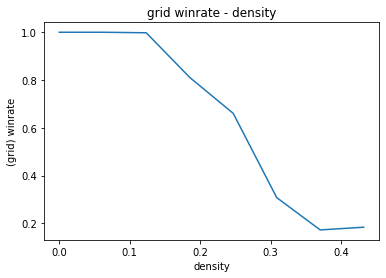

In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

r1 = []
r2 = []
for i in range(8):
    r1.append(d_exp[i][0][0]/d_exp[i][0][1])
    r2.append(d_exp[i][1][0]/d_exp[i][1][1])

plt.plot(np.asarray(list(range(0,8)))*5/81, r1)
plt.title('grid winrate - density')
plt.xlabel('density')
plt.ylabel('(grid) winrate')
plt.show()


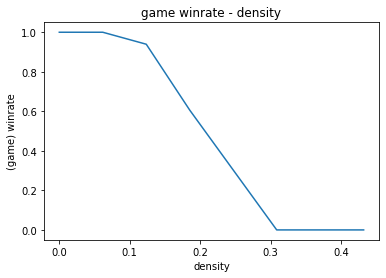

In [48]:
plt.plot(np.asarray(list(range(0,8)))*5/81, r2)
plt.title('game winrate - density')
plt.xlabel('density')
plt.ylabel('(game) winrate')
plt.show()